# Two clouds (with propper prediction)
### Data import

In [87]:
from warnings import simplefilter
from sklearn.decomposition import PCA
simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import numpy as np

In [88]:
data = pd.read_csv("Genotyped.csv", index_col='index')
output = pd.read_csv("Phenotypes.csv", index_col='index')

In [89]:
X = data
y = output.iloc[:, -1]

### Data slicing and Feature selection

In [90]:
from sklearn.feature_selection import SelectKBest, f_regression

skb = SelectKBest(f_regression, k=500)
skb.fit(X, y)
X = skb.transform(X)

In [91]:
type(X)

numpy.ndarray

In [92]:
X.shape

(599, 500)

In [93]:
from sklearn.model_selection import train_test_split

split = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split, random_state=42)

In [94]:
from sklearn.cluster import KMeans
clustering = KMeans(n_clusters=2, random_state=0).fit(X_train)

In [95]:
X_one = X_train[clustering.labels_ == 0]
y_one = y_train[clustering.labels_ == 0]

X_two = X_train[clustering.labels_ == 1]
y_two = y_train[clustering.labels_ == 1]

### Training the model

In [96]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR

In [97]:
classifier = SVR(kernel='rbf') 

#### With SVR kernel

In [98]:
grid = {
    'C' : [10**i for i in range(-10,10,2)] ,
    'gamma' : [2**i for i in range(-10,10,2)]
   }

In [99]:
gd_sr = GridSearchCV(estimator=classifier,
                       param_grid=grid,
                       scoring='r2',
                       cv=5, iid=False)

In [100]:
gd_sr.fit(X_one, y_one)

GridSearchCV(cv=5, estimator=SVR(), iid=False,
             param_grid={'C': [1e-10, 1e-08, 1e-06, 0.0001, 0.01, 1, 100, 10000,
                               1000000, 100000000],
                         'gamma': [0.0009765625, 0.00390625, 0.015625, 0.0625,
                                   0.25, 1, 4, 16, 64, 256]},
             scoring='r2')

In [101]:
best_parameters_one = gd_sr.best_params_
best_parameters_one

{'C': 1, 'gamma': 0.015625}

In [102]:
best_clf_one = SVR(kernel='rbf',C=best_parameters_one['C'])
best_clf_one.fit(X_one, y_one)

SVR(C=1)

In [103]:
gd_sr.fit(X_two, y_two)

GridSearchCV(cv=5, estimator=SVR(), iid=False,
             param_grid={'C': [1e-10, 1e-08, 1e-06, 0.0001, 0.01, 1, 100, 10000,
                               1000000, 100000000],
                         'gamma': [0.0009765625, 0.00390625, 0.015625, 0.0625,
                                   0.25, 1, 4, 16, 64, 256]},
             scoring='r2')

In [104]:
best_parameters_two = gd_sr.best_params_
best_parameters_two

{'C': 1, 'gamma': 0.015625}

In [105]:
best_clf_two = SVR(kernel='rbf',C=best_parameters_two['C'])
best_clf_two.fit(X_two, y_two)

SVR(C=1)

In [106]:
bin_i = clustering.predict(X_test)
y_pred = []

for i, el in enumerate(X_test):
    if bin_i[i] == 0:
        y_pred.append(best_clf_one.predict([el]))
    else:
        y_pred.append(best_clf_two.predict([el]))

In [107]:
y_pred = np.array(y_pred)

In [108]:
bin_i = clustering.predict(X_train)
y_pred_tr = []

for i, el in enumerate(X_train):
    if bin_i[i] == 0:
        y_pred_tr.append(best_clf_one.predict([el]))
    else:
        y_pred_tr.append(best_clf_one.predict([el]))

In [109]:
y_pred_tr = np.array(y_pred_tr)

### Evaluation (SVR kernel)

In [112]:
from sklearn.metrics import r2_score
print('Training set:',r2_score(y_train,y_pred_tr))
print('Test set:',r2_score(y_test,y_pred))

Training set: 0.23052299776001872
Test set: 0.21640640010672318


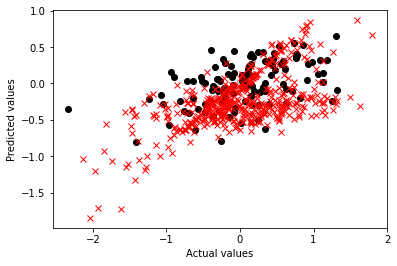

In [113]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.xlabel("Actual values")
plt.ylabel("Predicted values")
plt.plot(y_test, y_pred, 'o', color='black')
plt.plot(y_train,y_pred_tr, 'x', color='red')
plt.show()

### Training with Using SVR linear

In [114]:
classifier = SVR(kernel='linear') 

In [115]:
grid = {
    'C' : [10**i for i in range(-10,10,1)] 
   }

In [116]:
gd_sr = GridSearchCV(estimator=classifier,
                       param_grid=grid,
                       scoring='r2', # note the use of scoring here.
                       cv=5, iid=False)

In [117]:
gd_sr.fit(X_one, y_one)

GridSearchCV(cv=5, estimator=SVR(kernel='linear'), iid=False,
             param_grid={'C': [1e-10, 1e-09, 1e-08, 1e-07, 1e-06, 1e-05, 0.0001,
                               0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000,
                               100000, 1000000, 10000000, 100000000,
                               1000000000]},
             scoring='r2')

In [118]:
best_parameters_one = gd_sr.best_params_
best_parameters_one

{'C': 0.01}

In [120]:
best_clf_one = SVR(kernel='linear',C=best_parameters_one['C'])
best_clf_one.fit(X_one,y_one)

SVR(C=0.01, kernel='linear')

In [122]:
bin_i = clustering.predict(X_test)
y_pred = []

for i, el in enumerate(X_test):
    if bin_i[i] == 0:
        y_pred.append(best_clf_one.predict([el]))
    else:
        y_pred.append(best_clf_two.predict([el]))
        
y_pred = np.array(y_pred)

In [123]:
bin_i = clustering.predict(X_train)
y_pred_tr = []

for i, el in enumerate(X_train):
    if bin_i[i] == 0:
        y_pred_tr.append(best_clf_one.predict([el]))
    else:
        y_pred_tr.append(best_clf_one.predict([el]))
        
y_pred_tr = np.array(y_pred_tr)

### Evaluation (SVR linear)

In [124]:
from sklearn.metrics import r2_score
print('Training set:',r2_score(y_train,y_pred_tr))
print('Test set:',r2_score(y_test,y_pred))

Training set: 0.30469790943649244
Test set: 0.20689968508594703


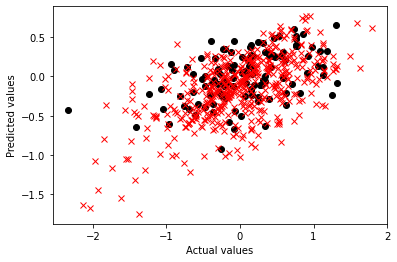

In [125]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.xlabel("Actual values")
plt.ylabel("Predicted values")
plt.plot(y_test, y_pred, 'o', color='black')
plt.plot(y_train,y_pred_tr, 'x', color='red')
plt.show()